In [1]:
import time
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch
import pytorch3d.ops
from plyfile import PlyData, PlyElement
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from argparse import ArgumentParser, Namespace
import cv2


from arguments import ModelParams, PipelineParams
from scene import Scene, GaussianModel, FeatureGaussianModel
from gaussian_renderer import render, render_contrastive_feature, render_with_depth

# import utils.contrastive_decoder_utils
from utils.sh_utils import SH2RGB

def get_combined_args(parser : ArgumentParser, model_path, target_cfg_file = None):
    cmdlne_string = ['--model_path', model_path]
    cfgfile_string = "Namespace()"
    args_cmdline = parser.parse_args(cmdlne_string)
    
    if target_cfg_file is None:
        if args_cmdline.target == 'seg':
            target_cfg_file = "seg_cfg_args"
        elif args_cmdline.target == 'scene' or args_cmdline.target == 'xyz':
            target_cfg_file = "cfg_args"
        elif args_cmdline.target == 'feature' or args_cmdline.target == 'coarse_seg_everything' or args_cmdline.target == 'contrastive_feature' :
            target_cfg_file = "feature_cfg_args"

    try:
        cfgfilepath = os.path.join(model_path, target_cfg_file)
        print("Looking for config file in", cfgfilepath)
        with open(cfgfilepath) as cfg_file:
            print("Config file found: {}".format(cfgfilepath))
            cfgfile_string = cfg_file.read()
    except TypeError:
        print("Config file found: {}".format(cfgfilepath))
        pass
    args_cfgfile = eval(cfgfile_string)

    merged_dict = vars(args_cfgfile).copy()
    for k,v in vars(args_cmdline).items():
        if v != None:
            merged_dict[k] = v

    return Namespace(**merged_dict)

# Hyper-parameters

In [2]:
import os
FEATURE_DIM = 32 # fixed

# MODEL_PATH = './output/lerf-fruit_aisle/'
MODEL_PATH = './output/room0' # 30000

FEATURE_GAUSSIAN_ITERATION = 10000

SCALE_GATE_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/scale_gate.pt')

FEATURE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/contrastive_feature_point_cloud.ply')
SCENE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/scene_point_cloud.ply')

# Data and Model Preparation


In [3]:
scale_gate = torch.nn.Sequential(
    torch.nn.Linear(1, 32, bias=True),
    torch.nn.Sigmoid()
)

scale_gate.load_state_dict(torch.load(SCALE_GATE_PATH))
scale_gate = scale_gate.cuda()

parser = ArgumentParser(description="Testing script parameters")
model = ModelParams(parser, sentinel=True)
pipeline = PipelineParams(parser)
parser.add_argument('--target', default='scene', type=str)

args = get_combined_args(parser, MODEL_PATH)

dataset = model.extract(args)

# If use language-driven segmentation, load clip feature and original masks
dataset.need_features = True

# To obtain mask scales
dataset.need_masks = True

scene_gaussians = GaussianModel(dataset.sh_degree)

feature_gaussians = FeatureGaussianModel(FEATURE_DIM)
scene = Scene(dataset, scene_gaussians, feature_gaussians, load_iteration=-1, feature_load_iteration=FEATURE_GAUSSIAN_ITERATION, shuffle=False, mode='eval', target='contrastive_feature')


Looking for config file in ./output/room0/cfg_args
Config file found: ./output/room0/cfg_args
Loading trained model at iteration 30000, 10000
Allow Camera Principle Point Shift: False
Reading camera 199/199
Loading Training Cameras
Loading Test Cameras


In [4]:
from sklearn.preprocessing import QuantileTransformer
# Borrowed from GARField, but modified
def get_quantile_func(scales: torch.Tensor, distribution="normal"):
    """
    Use 3D scale statistics to normalize scales -- use quantile transformer.
    """
    scales = scales.flatten()

    scales = scales.detach().cpu().numpy()
    print(scales.max(), '?')

    # Calculate quantile transformer
    quantile_transformer = QuantileTransformer(output_distribution=distribution)
    quantile_transformer = quantile_transformer.fit(scales.reshape(-1, 1))

    
    def quantile_transformer_func(scales):
        scales_shape = scales.shape

        scales = scales.reshape(-1,1)
        
        return torch.Tensor(
            quantile_transformer.transform(scales.detach().cpu().numpy())
        ).to(scales.device).reshape(scales_shape)

    return quantile_transformer_func, quantile_transformer
    
all_scales = []
for cam in scene.getTrainCameras():
    # print(cam.original_masks.shape)
    all_scales.append(cam.mask_scales)

all_scales = torch.cat(all_scales)

# print(all_scales.shape)

upper_bound_scale = all_scales.max().item()
# upper_bound_scale = np.percentile(all_scales.detach().cpu().numpy(), 75)

# all_scales = []
# for cam in scene.getTrainCameras():
#     cam.mask_scales = torch.clamp(cam.mask_scales, 0, upper_bound_scale).detach()
#     all_scales.append(cam.mask_scales)
# all_scales = torch.cat(all_scales)

# quantile transformer
q_trans, q_trans_ = get_quantile_func(all_scales, 'uniform')

18.116934 ?


In [5]:
all_scales.max()

tensor(18.1169, grad_fn=<MaxBackward1>)

In [18]:
# For saving the normal q_trans, if the q_trans is uniform, we don't have to save it

# from joblib import dump, load
# dump(q_trans_, 'quantile_trans_test.jl')
# a = load('quantile_trans_test.jl')

In [19]:
upper_bound_scale

18.116933822631836

In [20]:
q_trans(torch.Tensor([70]))

tensor([1.])

# Begin Segmenting

In [6]:
from copy import deepcopy
cameras = scene.getTrainCameras()
print("There are",len(cameras),"views in the dataset.")
print(upper_bound_scale)

There are 199 views in the dataset.
18.116933822631836


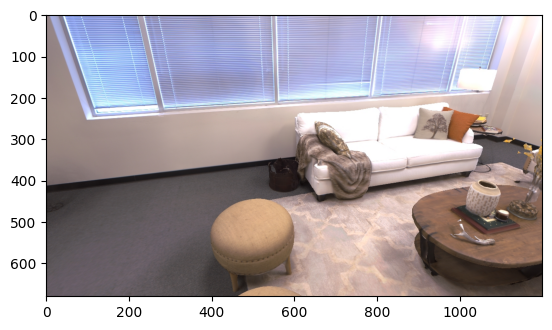

In [8]:
## SOFA
ref_img_camera_id = 179
# ref_img_camera_id = 62

# ref_img_camera_id = 125
# ref_img_camera_id = 144

# ref_img_camera_id = 21
# ref_img_camera_id = 34

view = deepcopy(cameras[ref_img_camera_id])

view.feature_height, view.feature_width = view.image_height, view.image_width
img = view.original_image * 255
img = img.permute([1,2,0]).detach().cpu().numpy().astype(np.uint8)

bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_feature = render_contrastive_feature(view, feature_gaussians, pipeline.extract(args), background, norm_point_features=True, smooth_type = None)['render']
feature_h, feature_w = rendered_feature.shape[-2:]


plt.imshow(img)

# Point Prompt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


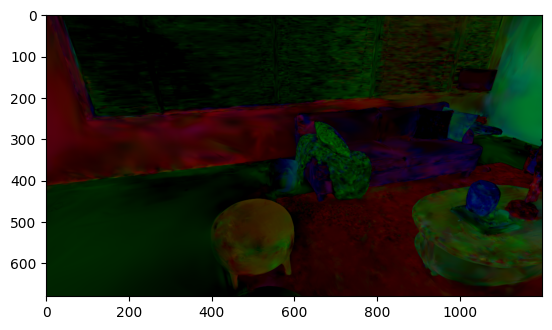

In [10]:
with torch.no_grad():
    # If the q_trans is normal
    # scale = 2.
    # scale = torch.full((1,), scale).cuda()
    # scale = q_trans(scale)

    # If the q_trans is uniform, the scale can be any value between 0 and 1
    # scale = torch.tensor([0]).cuda()
    # scale = torch.tensor([0.5]).cuda()
    # scale = torch.tensor([2.0]).cuda()

    # gates = scale_gate(scale)

    feature_with_scale = rendered_feature
    # feature_with_scale = feature_with_scale * gates.unsqueeze(-1).unsqueeze(-1)
    scale_conditioned_feature = feature_with_scale.permute([1,2,0])

    plt.imshow(scale_conditioned_feature[:,:,:3].detach().cpu().numpy())

torch.Size([32, 1])
torch.Size([680, 1200])


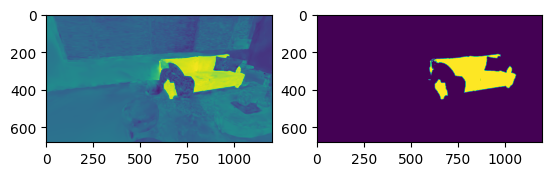

In [12]:
# query_index = (400, 500)
# query_index = (300, 800)

# query_indices = np.array([[400, 500], [450, 500], [500, 500]])

query_indices = np.array([[300, 800]])

normed_features = torch.nn.functional.normalize(scale_conditioned_feature, dim = -1, p = 2)

for id, query_index in enumerate(query_indices):
    query_index = [
        int(query_index[0] / view.image_height * view.feature_height),
        int(query_index[1] / view.image_width * view.feature_width)
        ]
    q_feature = normed_features[query_index[0], query_index[1]].reshape(-1, 1)
    if id == 0:
        query_features = q_feature
    else:
        query_features = torch.cat([query_features, q_feature], dim=-1)

print(query_features.shape)

similarity = normed_features @ query_features # (H, W, k)
similarity = torch.max(similarity, dim=-1).values

# similarity = torch.einsum('C,HWC->HW', query_feature, normed_features)

plt.subplot(1,2,1)
plt.imshow(similarity.detach().cpu().numpy())
plt.subplot(1,2,2)
plt.imshow(similarity.detach().cpu().numpy() > 0.6)

print(similarity.shape)

In [12]:
def save_same_shape(image, save_path):
    H, W = image.shape[:2]
    dpi = 100  # 设置每英寸点数，可以根据需要修改

    fig = plt.figure(figsize=(W / dpi, H / dpi), dpi=dpi)
    ax = plt.Axes(fig, [0, 0, 1, 1])  # 去除边框、填满整个画布
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(image)
    plt.savefig(save_path, dpi=dpi, bbox_inches='tight', pad_inches=0)
    # plt.close(fig)

### render masked image for mast3r
rendered_image = render(view, scene_gaussians, pipeline.extract(args), background)['render']
rendered_image = rendered_image.permute([1,2,0]).detach().cpu().numpy()
similarity = similarity.detach().cpu().numpy()
similarity[similarity < 0.6] = 0
similarity[similarity != 0] = 1
rendered_image = rendered_image * similarity[:, :, None]
print(rendered_image.shape)
# save_same_shape(rendered_image, '/workspace/SegAnyGAussians/output/room0/seg_obj/ottoman_2.png')


(680, 1200, 3)


In [ ]:
def geotrf(Trf, pts, ncol=None, norm=False):
    """ Apply a geometric transformation to a list of 3-D points.

    H: 3x3 or 4x4 projection matrix (typically a Homography)
    p: numpy/torch/tuple of coordinates. Shape must be (...,2) or (...,3)

    ncol: int. number of columns of the result (2 or 3)
    norm: float. if != 0, the resut is projected on the z=norm plane.

    Returns an array of projected 2d points.
    """
    assert Trf.ndim >= 2
    if isinstance(Trf, np.ndarray):
        pts = np.asarray(pts)
    elif isinstance(Trf, torch.Tensor):
        pts = torch.as_tensor(pts, dtype=Trf.dtype)

    # adapt shape if necessary
    output_reshape = pts.shape[:-1]
    ncol = ncol or pts.shape[-1]

    # optimized code
    if (isinstance(Trf, torch.Tensor) and isinstance(pts, torch.Tensor) and
            Trf.ndim == 3 and pts.ndim == 4):
        d = pts.shape[3]
        if Trf.shape[-1] == d:
            pts = torch.einsum("bij, bhwj -> bhwi", Trf, pts)
        elif Trf.shape[-1] == d + 1:
            pts = torch.einsum("bij, bhwj -> bhwi", Trf[:, :d, :d], pts) + Trf[:, None, None, :d, d]
        else:
            raise ValueError(f'bad shape, not ending with 3 or 4, for {pts.shape=}')
    else:
        if Trf.ndim >= 3:
            n = Trf.ndim - 2
            assert Trf.shape[:n] == pts.shape[:n], 'batch size does not match'
            Trf = Trf.reshape(-1, Trf.shape[-2], Trf.shape[-1])

            if pts.ndim > Trf.ndim:
                # Trf == (B,d,d) & pts == (B,H,W,d) --> (B, H*W, d)
                pts = pts.reshape(Trf.shape[0], -1, pts.shape[-1])
            elif pts.ndim == 2:
                # Trf == (B,d,d) & pts == (B,d) --> (B, 1, d)
                pts = pts[:, None, :]

        if pts.shape[-1] + 1 == Trf.shape[-1]:
            Trf = Trf.swapaxes(-1, -2)  # transpose Trf
            pts = pts @ Trf[..., :-1, :] + Trf[..., -1:, :]
        elif pts.shape[-1] == Trf.shape[-1]:
            Trf = Trf.swapaxes(-1, -2)  # transpose Trf
            pts = pts @ Trf
        else:
            pts = Trf @ pts.T
            if pts.ndim >= 2:
                pts = pts.swapaxes(-1, -2)

    if norm:
        pts = pts / pts[..., -1:]  # DONT DO /= BECAUSE OF WEIRD PYTORCH BUG
        if norm != 1:
            pts *= norm

    res = pts[..., :ncol].reshape(*output_reshape, ncol)
    return res

def inv(mat):
    """ Invert a torch or numpy matrix
    """
    if isinstance(mat, torch.Tensor):
        return torch.linalg.inv(mat)
    if isinstance(mat, np.ndarray):
        return np.linalg.inv(mat)
    raise ValueError(f'bad matrix type = {type(mat)}')


def mask110(device, dtype):
    return torch.tensor((1, 1, 0), device=device, dtype=dtype)


def proj3d(inv_K, pixels, z):
    inv_K = torch.tensor(inv_K, dtype=torch.float32, device="cuda")
    pixels = torch.tensor(pixels, dtype=torch.float32, device="cuda")
    z = torch.tensor(z, dtype=torch.float32, device="cuda")
    if pixels.shape[-1] == 2:
        pixels = torch.cat((pixels, torch.ones_like(pixels[..., :1])), dim=-1)
    return z.unsqueeze(-1) * (pixels * inv_K.diag() + inv_K[:, 2] * mask110(z.device, z.dtype))


rendered_pkg = render_with_depth(view, scene_gaussians, pipeline.extract(args), background)
depth = rendered_pkg['depth']
depth = depth.detach().cpu().numpy().squeeze()

matches_sofa_1 = np.load('/workspace/SegAnyGAussians/output/room0/seg_obj/matches_sofa_1.npy')
matches_sofa_2 = np.load('/workspace/SegAnyGAussians/output/room0/seg_obj/matches_sofa_2.npy')

# print(view.image_width, view.image_height)

K = view.intrinsics
inv_K = inv(K)
pixels = np.zeros((matches_sofa_2.shape[0], matches_sofa_2.shape[1])).astype(np.int16)
pixels[:, 0] = (matches_sofa_2[:, 0] * view.image_width).astype(np.int16)
pixels[:, 1] = (matches_sofa_2[:, 1] * view.image_height).astype(np.int16)

target_pixels = np.zeros((matches_sofa_1.shape[0], matches_sofa_1.shape[1])).astype(np.int16)
target_pixels[:, 0] = (matches_sofa_1[:, 0] * view.image_width).astype(np.int16)
target_pixels[:, 1] = (matches_sofa_1[:, 1] * view.image_height).astype(np.int16)

z = []
for p in pixels:
    z.append(depth[p[1], p[0]])
z = np.array(z)

Rt = np.zeros((4, 4))
Rt[:3, :3] = view.R.transpose()
Rt[:3, 3] = view.T
Rt[3, 3] = 1.0
cam2w = np.linalg.inv(Rt)
print(cam2w)
print(view.R, view.T)

cam2w = torch.tensor(cam2w, dtype=torch.float32, device="cuda")
pts3d = proj3d(inv_K, pixels, z)
pts3d = geotrf(cam2w, pts3d)
pts3d = pts3d.detach().cpu().numpy().astype(np.float32)
target_pixels = target_pixels.astype(np.float32)
# print(pts3d)

import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts3d.reshape(-1, 3))
o3d.io.write_point_cloud("/workspace/SegAnyGAussians/output/room0/seg_obj/sofa_keypoints.ply", pcd)

# 使用RANSAC + PnP求解相机姿态
success, rvec, tvec, inliers = cv2.solvePnPRansac(
    objectPoints=pts3d,
    imagePoints=target_pixels,
    cameraMatrix=view.intrinsics.detach().cpu().numpy(),
    distCoeffs=np.zeros(5),  # Assuming no lens distortion
    # iterationsCount=1000,
    # reprojectionError=2.0,
    # confidence=0.999,
    flags=cv2.SOLVEPNP_ITERATIVE
)
if success:
    # print("Rotation vector (rvec):\n", rvec)
    # print("Translation vector (tvec):\n", tvec)
    # print("Inliers:\n", inliers.shape)
    # 将 rvec 转换为旋转矩阵
    R_source, _ = cv2.Rodrigues(rvec)
    # print("Rotation matrix:\n", R_source)
else:
    print("PnP estimation failed.")

new_cam2w = np.eye(4)
new_cam2w[:3, :3] = R_source
new_cam2w[:3, 3] = tvec.flatten()
new_w2cam = np.linalg.inv(new_cam2w)
print("New camera to world transformation matrix:\n", new_w2cam)


[[-0.71023674 -0.12924633  0.6919965  -2.36393981]
 [ 0.27311812  0.85541299  0.44008534 -0.46175393]
 [-0.64882221  0.50156156 -0.57224622  3.85121455]
 [ 0.          0.          0.          1.        ]]
[[-0.71023674 -0.12924633  0.6919965 ]
 [ 0.27311812  0.85541299  0.44008534]
 [-0.64882221  0.50156156 -0.57224622]] [ 0.94591    -1.84216141  4.04289219]


/tmp/ipykernel_2722187/1515777391.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inv_K = torch.tensor(inv_K, dtype=torch.float32, device="cuda")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
New camera to world transformation matrix:
 [[-0.80377091 -0.21034743  0.5565126  -2.38255998]
 [ 0.19305281  0.79257996  0.57840091 -0.39942774]
 [-0.56274588  0.57233815 -0.59644456  3.71997413]
 [ 0.          0.          0.          1.        ]]


In [52]:
view_2 = cameras[21]

Rt = np.zeros((4, 4))
Rt[:3, :3] = view_2.R.transpose()
Rt[:3, 3] = view_2.T
Rt[3, 3] = 1.0
cam2w_2 = np.linalg.inv(Rt)
print(cam2w_2)
# print(view_2.R, view_2.T)

pcd = o3d.io.read_point_cloud("/workspace/SegAnyGAussians/segmentation_res/ottoman/ottoman_2.ply")
pcd_points = np.asarray(pcd.points)
pcd_points_homo = np.hstack((pcd_points, np.ones((pcd_points.shape[0], 1)))).transpose()
trans_pcd_points_homo = cam2w_2 @ np.linalg.inv(new_w2cam) @ pcd_points_homo

trans_pcd_points = trans_pcd_points_homo.transpose()[:, :3]
# print(trans_pcd_points)
trans_pcd = o3d.geometry.PointCloud()
trans_pcd.points = o3d.utility.Vector3dVector(trans_pcd_points)
o3d.io.write_point_cloud("/workspace/SegAnyGAussians/segmentation_res/ottoman/trans_ottoman_2.pcd", trans_pcd)


[[-0.76736149 -0.22553589  0.60024154 -4.98911323]
 [ 0.24799604  0.75886511  0.6021808   0.15085422]
 [-0.59131574  0.61094788 -0.52639185  1.58388543]
 [ 0.          0.          0.          1.        ]]


True

In [ ]:
target = o3d.io.read_point_cloud("/workspace/SegAnyGAussians/segmentation_res/ottoman/ottoman_1.ply")
source = trans_pcd
threshold = 0.08
# trans_init = np.asarray([[0.862, 0.011, -0.507, 0.5],
#                          [-0.139, 0.967, -0.215, 0.7],
#                          [0.487, 0.255, 0.835, -1.4], [0.0, 0.0, 0.0, 1.0]])
trans_init = np.eye(4)
print("Initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(
    source, target, threshold, trans_init)
print(evaluation)

print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=3000))
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
# evaluation = o3d.pipelines.registration.evaluate_registration(
#     source.transform(reg_p2p.transformation), target, threshold, trans_init)
# print(evaluation)
source.transform(reg_p2p.transformation)
o3d.io.write_point_cloud("/workspace/SegAnyGAussians/segmentation_res/ottoman/ottoman_2_aligned.ply", source)


Initial alignment
RegistrationResult with fitness=9.011036e-01, inlier_rmse=3.577035e-02, and correspondence_set size of 21066
Access transformation to get result.
Apply point-to-point ICP
RegistrationResult with fitness=9.041834e-01, inlier_rmse=3.573306e-02, and correspondence_set size of 21138
Access transformation to get result.
Transformation is:
[[ 0.99999124 -0.00338031  0.00246879 -0.02473648]
 [ 0.00339613  0.99997356 -0.00643078  0.07227239]
 [-0.00244698  0.00643911  0.99997627 -0.01530706]
 [ 0.          0.          0.          1.        ]]


True

In [1]:
import open3d as o3d
import numpy as np

def estimate_transform_matrix(src_points, dst_points):
    """
    src_points: [N, 3] numpy array (source point cloud, e.g. A)
    dst_points: [N, 3] numpy array (destination point cloud, e.g. B)
    Returns:
        4x4 transformation matrix (rotation + translation)
    """
    assert src_points.shape == dst_points.shape
    N = src_points.shape[0]

    # Compute centroids
    centroid_src = np.mean(src_points, axis=0)
    centroid_dst = np.mean(dst_points, axis=0)

    # Centralize
    src_centered = src_points - centroid_src
    dst_centered = dst_points - centroid_dst

    # Compute covariance matrix
    H = src_centered.T @ dst_centered

    # SVD
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # Fix improper rotation (reflection)
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    # Compute translation
    t = centroid_dst - R @ centroid_src

    # Construct 4x4 matrix
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = t

    return T

A_pcd = o3d.io.read_point_cloud("/workspace/SegAnyGAussians/segmentation_res/ottoman/ottoman_2.ply")
B_pcd = o3d.io.read_point_cloud("/workspace/SegAnyGAussians/segmentation_res/ottoman/ottoman_2_aligned.ply")

A = np.array(A_pcd.points)
B = np.array(B_pcd.points)

# 求解估计的 T
T_est = estimate_transform_matrix(A, B)

print("Estimated T:\n", T_est)
np.save("/workspace/SegAnyGAussians/segmentation_res/ottoman/transform.npy", T_est)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Estimated T:
 [[ 0.99965529  0.01652575 -0.02040099 -2.39441457]
 [-0.01709996  0.99945319 -0.02830023  0.66093093]
 [ 0.01992215  0.02863934  0.99939126 -1.72729182]
 [ 0.          0.          0.          1.        ]]


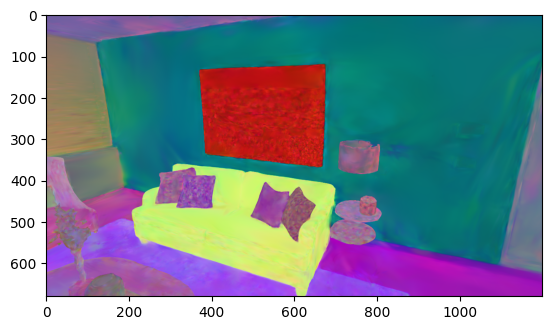

In [57]:
# SHOW PCA in 2D

# CHW -> PCA dimension reduction DHW (D=3)

from sklearn.decomposition import PCA

pca = PCA(n_components=3)


# t = pca.fit_transform(torch.nn.functional.normalize(rendered_feature, dim = 0).reshape(rendered_feature.shape[0], -1).permute([1,0]).cpu().detach().numpy())
t = pca.fit_transform(normed_features.reshape(-1, normed_features.shape[-1]).cpu().detach().numpy())

t = (t - t.min(axis=0)) / (t.max(axis=0)-t.min(axis=0))
t = t.reshape(normed_features.shape[0], normed_features.shape[1], 3)
plt.imshow(t)

# Cluster in 2D

In [33]:
downsampled_features = torch.nn.functional.interpolate(scale_conditioned_feature.permute([2,0,1]).unsqueeze(0), (128, 128), mode = 'bilinear').squeeze()
cluster_normed_features = torch.nn.functional.normalize(downsampled_features, dim = 0, p = 2).permute([1,2,0])

In [34]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, cluster_selection_epsilon=0.05)
cluster_labels = clusterer.fit_predict(cluster_normed_features.reshape([-1, cluster_normed_features.shape[-1]]).detach().cpu().numpy())
labels = cluster_labels.reshape([cluster_normed_features.shape[0], cluster_normed_features.shape[1]])
print(np.unique(labels))

cluster_centers = torch.zeros(len(np.unique(labels))-1, cluster_normed_features.shape[-1])
for i in range(1, len(np.unique(labels))):
    cluster_centers[i-1] = torch.nn.functional.normalize(cluster_normed_features[labels == i-1].mean(dim = 0), dim = -1)

label_to_color = np.random.rand(200, 3)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48]


In [35]:

label_to_color = np.random.rand(200, 3)
segmentation_res = torch.einsum('nc,hwc->hwn', cluster_centers.cuda(), normed_features)

segmentation_res_idx = segmentation_res.argmax(dim = -1)
colored_labels = label_to_color[segmentation_res_idx.cpu().numpy().astype(np.int8)]

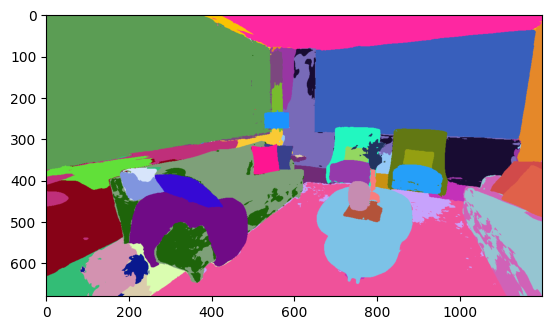

In [36]:
plt.imshow(colored_labels)

# Segmentation in 3D

After obtaining query features, we can use it to segment objects in 3D.

In [9]:
point_features = feature_gaussians.get_point_features

# scale_conditioned_point_features = point_features * gates.unsqueeze(0)
scale_conditioned_point_features = point_features


In [10]:
normed_scale_conditioned_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)
 
similarities = normed_scale_conditioned_point_features @ query_features # (N, k)

similarities = torch.max(similarities, dim=-1).values

# similarities = torch.einsum('C,NC->N', query_feature.cuda(), normed_scale_conditioned_point_features)

similarities[similarities < 0.7] = 0

In [11]:
bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_similarities = render(cameras[ref_img_camera_id], scene_gaussians, pipeline.extract(args), background, override_color=similarities.unsqueeze(-1).repeat([1,3]))['render']

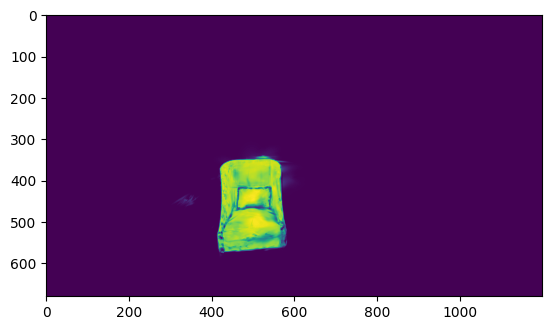

In [12]:
plt.imshow(rendered_similarities.permute([1,2,0])[:,:,0].detach().cpu())

In [13]:
try:
    scene_gaussians.roll_back()
except:
    pass
scene_gaussians.segment(similarities>0)

In [14]:
# save the segmentation
name = 'precomputed_mask'
import os
os.makedirs('./segmentation_res', exist_ok=True)
torch.save(similarities > 0.5, f'./segmentation_res/{name}.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


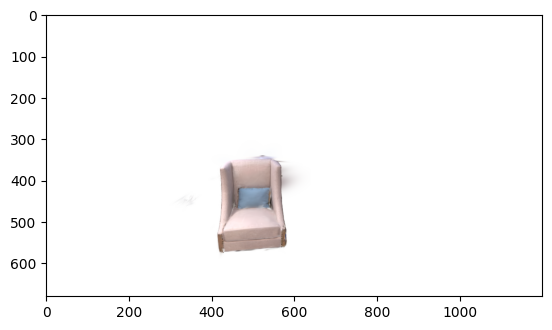

In [15]:
bg_color = [1 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_segmented_image = render(cameras[ref_img_camera_id], scene_gaussians, pipeline.extract(args), background)['render']
plt.imshow(rendered_segmented_image.permute([1,2,0]).detach().cpu())
scene_gaussians.save_ply("./segmentation_res/armchair/armchair_1.ply")

# print(cameras[ref_img_camera_id].T)

# xyz = scene_gaussians._xyz
# # === HDBSCAN 聚类 ===
# clusterer = hdbscan.HDBSCAN(min_cluster_size=30)  # 小于30的簇会被标为-1（噪声）
# labels = clusterer.fit_predict(xyz.detach().cpu().numpy())
# hdscan_mask = labels != -1
# print(np.unique(labels))
# scene_gaussians.segment(hdscan_mask)


In [44]:
scene_gaussians.roll_back()

# Cluster in 3D

In [ ]:
point_features = feature_gaussians.get_point_features

scale_conditioned_point_features = torch.nn.functional.normalize(point_features, dim = -1, p = 2) * gates.unsqueeze(0)

normed_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)

sampled_point_features = scale_conditioned_point_features[torch.rand(scale_conditioned_point_features.shape[0]) > 0.99]

normed_sampled_point_features = sampled_point_features / torch.norm(sampled_point_features, dim = -1, keepdim = True)

print(len(sampled_point_features))

41515


In [ ]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=30, cluster_selection_epsilon=0.1)

cluster_labels = clusterer.fit_predict(normed_sampled_point_features.detach().cpu().numpy())
print(np.unique(cluster_labels))

cluster_centers = torch.zeros(len(np.unique(cluster_labels))-1, normed_sampled_point_features.shape[-1])
for i in range(1, len(np.unique(cluster_labels))):
    cluster_centers[i-1] = torch.nn.functional.normalize(normed_sampled_point_features[cluster_labels == i-1].mean(dim = 0), dim = -1)

print(cluster_centers.shape)
print(cluster_centers)

Cluster Similarity Matrix:
tensor([[ 1.0000,  0.1511,  0.0630,  ...,  0.0274, -0.0167,  0.0433],
        [ 0.1511,  1.0000, -0.1619,  ...,  0.1142, -0.0206, -0.0856],
        [ 0.0630, -0.1619,  1.0000,  ..., -0.0567,  0.2128,  0.1765],
        ...,
        [ 0.0274,  0.1142, -0.0567,  ...,  1.0000,  0.0563,  0.3297],
        [-0.0167, -0.0206,  0.2128,  ...,  0.0563,  1.0000,  0.4819],
        [ 0.0433, -0.0856,  0.1765,  ...,  0.3297,  0.4819,  1.0000]],
       grad_fn=<ViewBackward0>)


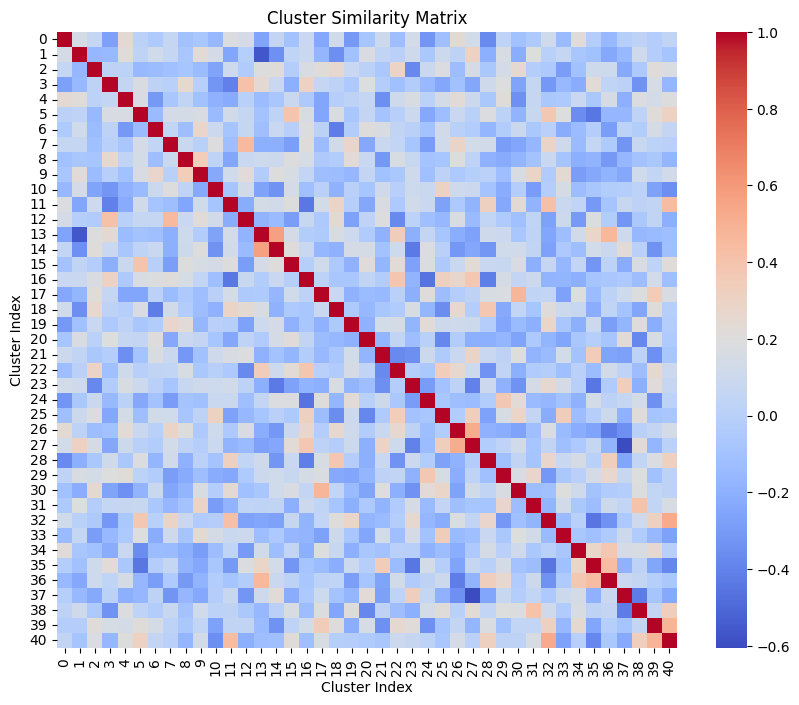

In [46]:
from torch.nn.functional import normalize

# 计算聚类中心之间的余弦相似度
# cluster_centers 是形状为 (num_clusters, feature_dim) 的张量
normalized_cluster_centers = normalize(cluster_centers, dim=-1, p=2)
similarity_matrix = torch.einsum('nc,mc->nm', normalized_cluster_centers, normalized_cluster_centers)

# 打印相似度矩阵
print("Cluster Similarity Matrix:")
print(similarity_matrix)

# 可视化相似度矩阵
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix.detach().numpy(), annot=False, fmt=".2f", cmap="coolwarm")
plt.title("Cluster Similarity Matrix")
plt.xlabel("Cluster Index")
plt.ylabel("Cluster Index")
plt.show()

In [ ]:
from torch.nn.functional import normalize

def find_best_camera(cameras, object_points):
    """
    找到能看到物体的最佳相机视角。
    
    Args:
        cameras: 场景中的所有相机。
        object_points: 物体的点云 (N, 3) 的坐标。
    
    Returns:
        best_camera: 最佳相机。
        best_camera_index: 最佳相机的索引。
    """
    # 计算物体的中心点
    object_center = object_points.mean(dim=0)

    best_camera = None
    best_camera_index = -1
    min_distance = float('inf')

    for i, camera in enumerate(cameras):
        # 获取相机的世界坐标
        camera_position = camera.CamFromWorld().translation

        # 计算相机到物体中心的距离
        distance = torch.norm(camera_position - object_center)

        if distance < min_distance:
            min_distance = distance
            best_camera = camera
            best_camera_index = i

    return best_camera, best_camera_index


cluster_centers = torch.tensor(cluster_centers, dtype=torch.float32, device="cuda")

# 计算聚类中心之间的余弦相似度
normalized_cluster_centers = normalize(cluster_centers, dim=-1, p=2)
similarity_matrix = torch.einsum('nc,mc->nm', normalized_cluster_centers, normalized_cluster_centers)

# 将自身与自身的相似度置为 -1（排除自身）
num_clusters = similarity_matrix.shape[0]
for i in range(num_clusters):
    similarity_matrix[i, i] = -1

# 找到每个物体与其相似度最近的物体
most_similar_indices = similarity_matrix.argmax(dim=1)

# 可视化每个物体与其最近物体的渲染
for i, similar_idx in enumerate(most_similar_indices):
    print(f"Object {i} is most similar to Object {similar_idx}")

    # 获取当前物体和最相似物体的特征
    current_object_features = cluster_centers[i]
    similar_object_features = cluster_centers[similar_idx]

    # 渲染当前物体
    current_object_similarity = torch.einsum('C,NC->N', current_object_features, normed_point_features)
    current_object_similarity[current_object_similarity < 0.7] = 0

    print(current_object_similarity.shape)

    # 渲染最相似物体
    similar_object_similarity = torch.einsum('C,NC->N', similar_object_features, normed_point_features)
    similar_object_similarity[similar_object_similarity < 0.7] = 0

    # 可视化当前物体
    bg_color = [1 for _ in range(FEATURE_DIM)]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
    rendered_current = render(
        cameras[0], scene_gaussians, pipeline.extract(args), background,
        override_color=current_object_similarity.unsqueeze(-1).repeat([1, 3])
    )['render']

    # 可视化最相似物体
    rendered_similar = render(
        cameras[100], scene_gaussians, pipeline.extract(args), background,
        override_color=similar_object_similarity.unsqueeze(-1).repeat([1, 3])
    )['render']

    # 显示结果
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"Object {i}")
    plt.imshow(rendered_current.permute([1, 2, 0]).detach().cpu().numpy())
    plt.subplot(1, 2, 2)
    plt.title(f"Most Similar to Object {i}: Object {similar_idx}")
    plt.imshow(rendered_similar.permute([1, 2, 0]).detach().cpu().numpy())
    plt.show()

In [47]:
seg_score = torch.einsum('nc,bc->bn', cluster_centers.cpu(), normed_point_features.cpu())

In [48]:
label_to_color = np.random.rand(1000, 3)
point_colors = label_to_color[seg_score.argmax(dim = -1).cpu().numpy()]
point_colors[seg_score.max(dim = -1)[0].detach().cpu().numpy() < 0.5] = (0,0,0)

In [49]:
try:
    scene_gaussians.roll_back()
except:
    pass

In [50]:
bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")


rendered_seg_map_2 = render(cameras[ref_img_camera_id], scene_gaussians, pipeline.extract(args), background, override_color=torch.from_numpy(point_colors).cuda().float())['render']
# rendered_seg_map = render(cameras[150], scene_gaussians, pipeline.extract(args), background, override_color=torch.from_numpy(point_colors).cuda().float())['render']

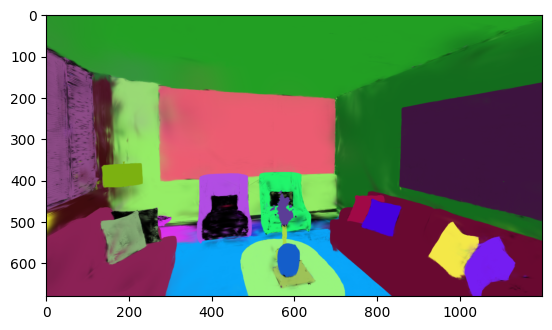

In [51]:
# plt.imshow(rendered_seg_map.permute([1,2,0]).detach().cpu().numpy())
# plt.show()
plt.imshow(rendered_seg_map_2.permute([1,2,0]).detach().cpu().numpy())
plt.show()

# Language-driven Segmentation

In [52]:
# sample some anchor points in 3D
anchor_point_features = feature_gaussians.get_point_features[torch.rand(feature_gaussians.get_point_features.shape[0]) > 0.99]
print(len(anchor_point_features))

20576


In [53]:
from copy import deepcopy

seg_features = []
clip_features = []
scales = []
mask_identifiers = []
camera_id_mask_id = []

# vote_weights = []

bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

i=0
for view in scene.getTrainCameras():
    torch.cuda.empty_cache()
    clip_features.append(view.original_features)
    tmp_view = deepcopy(view)
    tmp_view.feature_height, tmp_view.feature_width = view.original_image.shape[-2:]

    rendered_feature = render_contrastive_feature(tmp_view, feature_gaussians, pipeline.extract(args), background, norm_point_features=True)['render']
    feature_h, feature_w = rendered_feature.shape[-2:]

    with torch.no_grad():
        # NOTE: 3D-OVS need 8x downsample since its images are in 4K resolution
        # rendered_feature = torch.nn.functional.interpolate(rendered_feature.unsqueeze(0), (feature_h // 8, feature_w // 8), mode = 'bilinear').squeeze()
        # sam_masks = view.original_masks.cuda().unsqueeze(1)
        # sam_masks = torch.nn.functional.interpolate(sam_masks, (feature_h // 8, feature_w // 8), mode = 'bilinear')

        rendered_feature = torch.nn.functional.interpolate(rendered_feature.unsqueeze(0), (feature_h // 4, feature_w // 4), mode = 'bilinear').squeeze()
        sam_masks = view.original_masks.cuda().unsqueeze(1)
        sam_masks = torch.nn.functional.interpolate(sam_masks.float(), (feature_h // 4, feature_w // 4), mode = 'bilinear')

        # plt.imshow(sam_masks[0, 0].detach().cpu().numpy(), cmap='gray')
        # plt.title("First Element of sam_masks")
        # plt.axis('off')  # 隐藏坐标轴
        # plt.show()

        # rendered_feature.shape: [C, H, W]
        # sam_masks.shape: [N, 1, H, W]
        # print("rendered_feature & sam_masks shape", rendered_feature.shape, sam_masks.shape)

        sam_masks = torch.conv2d(
            sam_masks.float().cpu(),
            torch.full((3, 3), 1.0).view(1, 1, 3, 3).cpu(),
            padding=1,
        )
        sam_masks = sam_masks >= 2
        sam_masks = sam_masks.cuda()


        # vote_weights is the number of pixels in the mask
        # vote_weights.append(sam_masks.sum(dim = -1).sum(dim = -1))

        # sam_masks = torch.nn.functional.interpolate(sam_masks.unsqueeze(1), (view.feature_height, view.feature_width), mode = 'bilinear')
        # sam_masks[sam_masks > 0.75] = 1
        # sam_masks[sam_masks != 1] = 0

        mask_scales = view.mask_scales.cuda().unsqueeze(-1)
        mask_scales = q_trans(mask_scales)

        # mask_scales.shape: [N, 1]
        # print(mask_scales)

        scale_gates = scale_gate(mask_scales)

        # scale_gates.shape: [N, C]
        # print(scale_gates.shape)
        
        # int_sampled_scales = ((1 - mask_scales.squeeze()) * 10).long()
        # scale_gates = fixed_scale_gate[int_sampled_scales].detach()

        # scale_conditioned_anchor_point_features.shape: [N, M, C]
        # scale_conditioned_anchor_point_features = torch.einsum('nc,mc->nmc',scale_gates, anchor_point_features)
        scale_conditioned_anchor_point_features = scale_gates.unsqueeze(1) * anchor_point_features.unsqueeze(0)
        scale_conditioned_anchor_point_features = torch.nn.functional.normalize(scale_conditioned_anchor_point_features, dim = -1, p = 2)

        # scale_conditioned_feature.shape: [N, C, H, W]
        scale_conditioned_feature = rendered_feature.unsqueeze(0) * scale_gates.unsqueeze(-1).unsqueeze(-1)
        scale_conditioned_feature = torch.nn.functional.normalize(scale_conditioned_feature, dim = 1, p = 2)

        # mask_features.shape: [N, C]
        # print(sam_masks.shape, scale_conditioned_feature.shape)
        mask_features = (sam_masks * scale_conditioned_feature).sum(dim = -1).sum(dim = -1) / (sam_masks.sum(dim = -1).sum(dim = -1) + 1e-9)
        mask_features = torch.nn.functional.normalize(mask_features, dim = -1, p = 2)

        mask_identifier = torch.einsum('nmc,nc->nm', scale_conditioned_anchor_point_features, mask_features) > 0.5
        
        mask_identifiers.append(mask_identifier.cpu())
        seg_features.append(mask_features)
        scales.append(view.mask_scales.cuda().unsqueeze(-1))

        if view.mask_scales.shape[0] != view.original_features.shape[0]:
            print(view.mask_scales.shape[0], view.original_features.shape[0])

        for j in range(len(mask_features)):
            camera_id_mask_id.append((i, j))
        i+=1

        
torch.cuda.empty_cache()

print(len(clip_features))

199


In [54]:
flattened_mask_features = torch.cat(seg_features, dim = 0)
flattened_clip_features = torch.cat(clip_features, dim = 0)
flattened_clip_features = torch.nn.functional.normalize(flattened_clip_features.float(), dim = -1, p = 2)
flattened_scales = torch.cat(scales, dim = 0)
flattened_mask_identifiers = torch.cat(mask_identifiers, dim = 0).to(torch.float16).cuda()
flattened_mask_features.shape, flattened_clip_features.shape, flattened_scales.shape, flattened_mask_identifiers.shape, len(camera_id_mask_id)

(torch.Size([4083, 32]),
 torch.Size([4083, 512]),
 torch.Size([4083, 1]),
 torch.Size([4083, 20576]),
 4083)

In [55]:

with torch.no_grad():
    distance_map = 1 - (torch.einsum('mc,nc->mn', flattened_mask_identifiers, flattened_mask_identifiers) / (flattened_mask_identifiers.sum(dim = -1).unsqueeze(-1) + flattened_mask_identifiers.sum(dim = -1).unsqueeze(0) - torch.einsum('mc,nc->mn', flattened_mask_identifiers, flattened_mask_identifiers) + 1e-6))

In [56]:
# Construct vote graph

from hdbscan import HDBSCAN

clusterer = HDBSCAN(min_cluster_size=30, cluster_selection_epsilon=0.25, metric='precomputed')
cluster_labels = clusterer.fit_predict(distance_map.detach().cpu().numpy().astype(np.float64))
cluster_labels = torch.from_numpy(cluster_labels).to(device = flattened_clip_features.device, dtype = torch.long)

In [57]:
print(cluster_labels.shape)
print(cluster_labels)

torch.Size([4083])
tensor([37, 15, 44,  ..., -1,  5, 31])


In [58]:
import importlib
import clip_utils
importlib.reload(clip_utils)
from clip_utils import get_scores_with_template
from clip_utils.clip_utils import load_clip
clip_model = load_clip()
clip_model.eval()

/root/miniconda3/envs/saga/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Embedding dimension 512


OpenCLIPNetwork(
  (model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
      (patch_dropout): Identity()
      (ln_pre): LayerNormFp32((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-11): 12 x ResidualAttentionBlock(
            (ln_1): LayerNormFp32((768,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNormFp32((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ls_2): Identity()
        

In [69]:
# Convert input text prompts to scores for multi-view masks

text = "conference table. office chair. sofa. cushion. armchair. bench. glass door. walls. ceiling lights. switches. carpet. ceiling."

scores = get_scores_with_template(clip_model, flattened_clip_features.cuda(), "ottoman")
print(scores.max(), scores.min(), scores.shape)
scores = scores.squeeze()

tensor(0.6955, device='cuda:0') tensor(0.1944, device='cuda:0') torch.Size([4083, 1])


In [70]:
cluster_scores = torch.zeros(len(torch.unique(cluster_labels)), device=cluster_labels.device)
for cluster_idx in torch.unique(cluster_labels):
    # print(cluster_idx)
    cluster_scores[cluster_idx+1] = scores[cluster_labels == cluster_idx].mean()

In [61]:
def cluster_id_to_scales(cluster_labels, flattened_scales, cluster_idx, scores):
    max_score_mask_scale_id = scores[cluster_labels == cluster_idx].argmax()
    return flattened_scales[cluster_labels == cluster_idx][max_score_mask_scale_id].item(), max_score_mask_scale_id

cluster_labels.unique(), cluster_labels.unique()[cluster_scores.argmax()], cluster_scores.max()

(tensor([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
         35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 tensor(23),
 tensor(0.5646))

In [71]:
good_clusters = torch.where(cluster_scores > 0.5)[0]
# print(good_clusters)
good_cluster_scores = cluster_scores[good_clusters]
if len(good_clusters) != 0:
    print(len(good_clusters))
    good_clusters = [cluster_labels.unique()[i] for i in good_clusters]
else:
    good_clusters = [cluster_labels.unique()[cluster_scores.argmax()]]

print(good_clusters)

clip_query_features = []
corresponding_scales = []

for g in good_clusters:

    s, ind = cluster_id_to_scales(cluster_labels, flattened_scales, g, scores)
    print(s, ind)
    print(flattened_mask_features[cluster_labels == g][ind])
    clip_query_features.append(torch.nn.functional.normalize(flattened_mask_features[cluster_labels == g][ind], dim = -1, p = 2))

    corresponding_scales.append(s)

# print(clip_query_features)
print(corresponding_scales)

3
[tensor(5), tensor(7), tensor(43)]
1.769018292427063 tensor(50, device='cuda:0')
tensor([ 0.0892,  0.0649, -0.0766, -0.0197,  0.1051,  0.0772, -0.0361, -0.0721,
        -0.0283,  0.0914, -0.2251, -0.0105,  0.0631,  0.1212, -0.2208,  0.0927,
        -0.0054, -0.0228, -0.1953, -0.1809,  0.4823, -0.2289, -0.0989, -0.1204,
         0.1537, -0.0023,  0.0487,  0.0527,  0.0584, -0.2603,  0.0558,  0.5816],
       device='cuda:0')
1.6014058589935303 tensor(18, device='cuda:0')
tensor([-0.2337, -0.1605, -0.0113, -0.0322,  0.0969, -0.3865,  0.2852, -0.3030,
         0.2116,  0.1101,  0.2861,  0.0666,  0.1588,  0.1175, -0.2528,  0.0005,
        -0.0346,  0.0825, -0.0575, -0.0388, -0.0867, -0.1326, -0.1702, -0.2543,
         0.0023, -0.0202,  0.3249,  0.0534,  0.2203, -0.1499,  0.1191, -0.1221],
       device='cuda:0')
2.0574588775634766 tensor(20, device='cuda:0')
tensor([ 2.1690e-02, -1.8341e-01,  1.4787e-02, -1.4644e-02, -7.3769e-01,
        -8.7512e-02,  1.2225e-01,  1.1337e-02, -7.5819e-02, 

In [72]:
from typing import Callable
def get_similarity_map(point_features:torch.Tensor, scale:float, scale_gate:Callable, clip_query_feature:torch.Tensor, q_trans:Callable[[torch.Tensor], torch.Tensor]):
    # scale = 0.5
    scale = torch.full((1,), scale).cuda()
    scale = q_trans(scale)

    gates = scale_gate(scale).detach().squeeze()

    # print(point_features.shape, gates.shape)

    scale_conditioned_point_features = point_features * gates.unsqueeze(0)

    normed_scale_conditioned_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)

    similarities = torch.einsum('C,NC->N', clip_query_feature, normed_scale_conditioned_point_features)

    return similarities


1.769018292427063
1.6014058589935303
2.0574588775634766


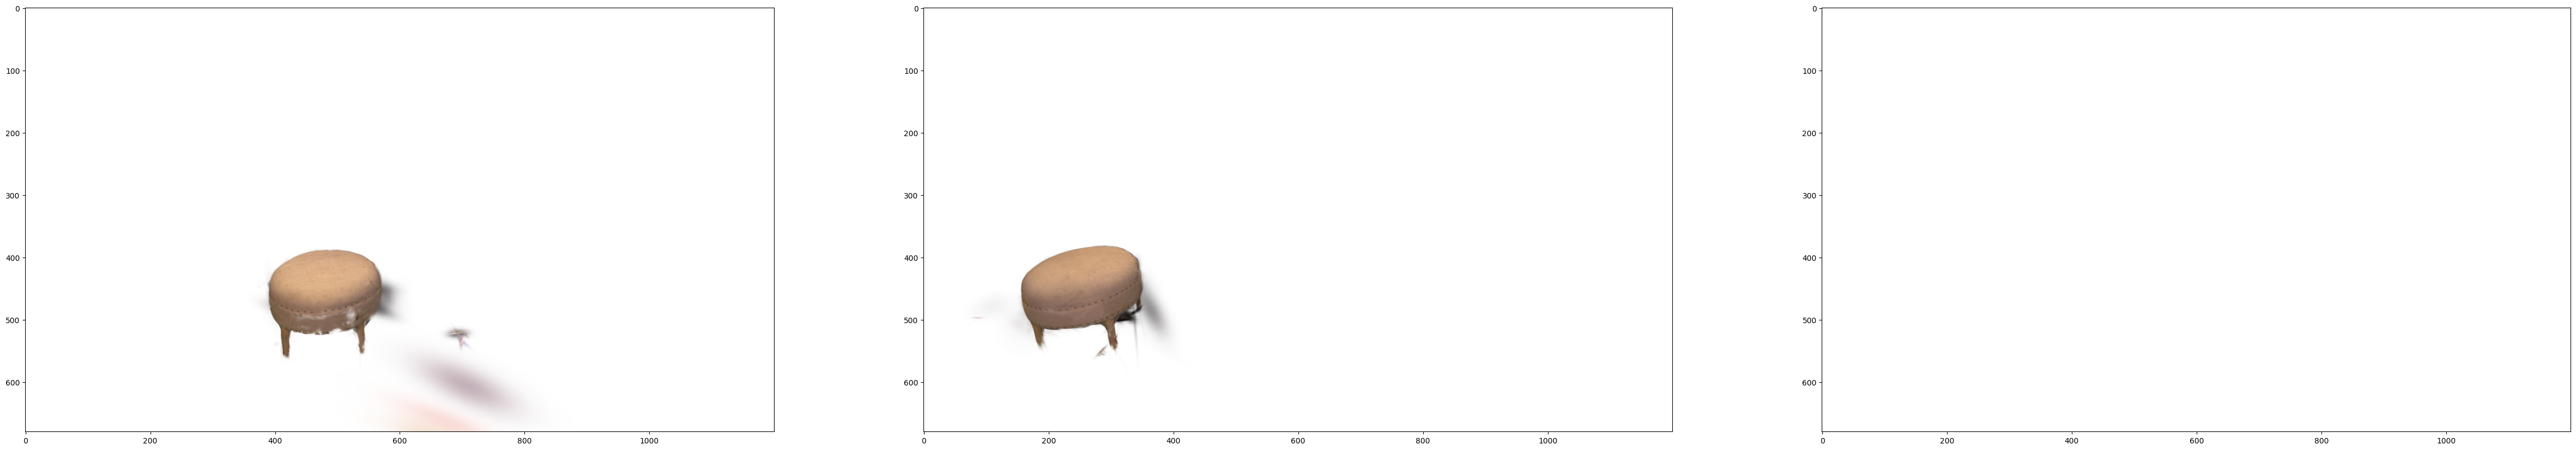

In [76]:
plt.figure(figsize=(60, 30))

for index in range(len(good_clusters)):

    similarities = get_similarity_map(feature_gaussians.get_point_features, corresponding_scales[index], scale_gate, clip_query_features[index], q_trans)
    print(corresponding_scales[index])
    try:
        scene_gaussians.roll_back()
    except:
        pass
    scene_gaussians.segment(similarities > 0.8)

    bg_color = [1 for i in range(FEATURE_DIM)]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
    rendered_segmented_image = render(cameras[21], scene_gaussians, pipeline.extract(args), background)['render']
    plt.subplot(1,len(good_clusters),index+1)
    plt.imshow(rendered_segmented_image.permute([1,2,0]).detach().cpu())
    # plt.axis('off')  # 可选：隐藏坐标轴


In [77]:
try:
    scene_gaussians.roll_back()
except:
    pass
scene_gaussians.segment(similarities > 0.5)

In [ ]:
bg_color = [1 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_segmented_image = render(cameras[21], scene_gaussians, pipeline.extract(args), background)['render']
plt.imshow(rendered_segmented_image.permute([1,2,0]).detach().cpu())
